<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/oil_error_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install catboost
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.model_selection import cross_validate
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
import plotly.express as px
import seaborn as sns

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def mape(a, b):
    a ,b = np.array(a) ,np.array(b)
    mask = a != 0
    return (np.fabs(a - b)/a)[mask].mean()

def rmse(y_t,y_p):
  return np.sqrt(mean_squared_error(y_t,y_p))

def metric(y_t,y_p,name):
  res = {'R2':np.clip(r2_score(y_t,y_p),0,1),
         'RMSE':rmse(y_t,y_p),
         'MAPE':mape(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

def clean(df):
  condition = (df['N+A']>=36)
  return df.loc[condition]

def get_result(y_test,y_pred):
  res = pd.DataFrame()
  for y_name in y_columns:
    row = metric(y_test[y_name],y_pred[y_name],y_name)
    res = res.append(row)
  res.loc['AVG'] = res.mean()
  return res

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# load

In [3]:
train_4521 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0)
test_170 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_170.csv',index_col=0)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
full = train_4521.append(test_170).append(test_250)
full.shape

(4941, 27)

# clean and drop duplicates

In [4]:
full = clean(full)
print(full.shape)
full = full.drop_duplicates()
full.shape

(2892, 27)


(2863, 27)

# define columns

In [0]:
cols = full.columns.tolist()
features = cols[:4]
y_columns = cols[4:]

# reset_index

In [6]:
full = full.reset_index(drop=True)
full.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,103.3,118.9,143.1,36.592,0.002,0.000,0.000,3.032,0.536,4.599,0.437,10.119,8.158,8.066,3.144,8.824,9.438,5.356,5.727,6.099,9.952,4.479,3.780,0.849,5.160,0.636,0.368
1,112.8,128.5,150.3,36.880,0.139,0.067,0.030,1.655,0.864,1.434,0.272,6.580,4.713,5.622,3.304,9.068,9.336,6.021,7.713,7.156,12.958,6.091,4.367,1.753,7.137,0.938,1.088
2,113.2,129.8,150.4,37.194,0.136,0.065,0.030,1.677,0.852,1.452,0.271,6.664,4.785,5.626,3.285,9.086,9.348,6.082,7.677,7.197,12.997,6.360,4.376,1.739,7.112,1.020,1.015
3,109.5,126.7,151.9,36.013,0.366,0.227,0.043,2.104,0.989,1.771,0.305,7.723,5.726,6.251,3.193,9.063,9.453,6.081,6.863,6.898,12.019,5.742,4.164,1.423,6.630,0.831,0.769
4,104.1,126.3,150.8,36.640,1.334,0.906,0.118,2.618,1.824,1.924,0.379,6.957,5.263,6.529,3.012,8.460,8.822,6.301,6.201,6.389,11.240,6.283,4.162,1.491,6.982,1.013,0.718


# model

In [0]:
base = CatBoostRegressor(learning_rate = 0.1,n_estimators = 100,verbose=0)
model = MultiOutputRegressor(base)

# split and train

In [8]:
X = full[features]
y = full[y_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 ,random_state=42)
model.fit(X_train,y_train)

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7f61bf5889b0>,
                     n_jobs=None)

# predict and metric

In [9]:
y_pred = pd.DataFrame(model.predict(X_test),columns=y_columns,index=y_test.index)
res = get_result(y_test,y_pred)
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.938494,0.621567,0.398196
C5IP,0.902514,0.560025,1.01008
C5N,0.0412632,0.217926,0.517409
C6NP,0.868869,0.496899,0.265918
C6IP,0.898023,0.56174,0.252485
C6N,0.817438,0.8054,0.41673
C6A,0.874873,0.953071,0.467615
C7NP,0.824712,0.617731,0.0669877
C7IP,0.732129,0.595014,0.0761022
C7N,0.852075,1.7333,0.117209


# count loss

In [0]:
loss = np.sqrt(np.square(y_test-y_pred))

# plot loss

In [11]:
y_name = 'C8A'
plot_data = X_test
plot_data[y_name] = y_test[y_name]
plot_data[y_name+'_pred'] = y_pred[y_name]
plot_data['loss'] = loss[y_name]
plot_data['index'] = X_test.index
fig = px.scatter(plot_data, x = y_name , y = "loss" ,color = "loss",size = "loss",hover_data=plot_data.columns)
fig.show()

In [12]:
high_loss_index = plot_data['loss'].sort_values(ascending=False).index
high_loss_index[:10]

Int64Index([1235, 1269, 1871, 612, 411, 2647, 1885, 2349, 2131, 1752], dtype='int64')

In [0]:
higlight_index = high_loss_index[0]
pred_like_index = list(abs(plot_data[y_name+'_pred'] - plot_data.loc[higlight_index,y_name+'_pred']).sort_values().index[1:4])
test_like_index = list(abs(plot_data[y_name] - plot_data.loc[higlight_index,y_name]).sort_values().index[1:4])

In [14]:
round(plot_data.loc[[higlight_index]+test_like_index+pred_like_index],2)

,T10,T50,T90,N+A,C8A,C8A_pred,loss,index
1235,92.3,117.6,146.3,53.28,19.38,6.36,13.03,1235
2349,109.8,126.4,146.1,44.72,19.06,14.11,4.94,2349
1269,92.6,116.6,146.4,52.71,18.26,5.99,12.26,1269
1885,104.5,122.8,147.5,46.97,15.97,10.63,5.34,1885
1352,103.6,120.7,145.9,37.12,5.76,6.35,0.59,1352
2630,96.5,116.8,142.8,52.73,6.53,6.34,0.19,2630
272,101.4,120.0,144.3,40.76,6.31,6.37,0.06,272


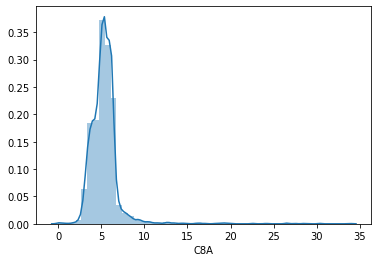

In [15]:
sns.distplot(full[y_name])